In [1]:
import sys
print(sys.version)

import torch

# 当前安装的 PyTorch 库的版本
print(torch.__version__)
# 检查 CUDA 是否可用，即你的系统有 NVIDIA 的 GPU
print(torch.backends.mps.is_available()) #检查mps是否可用

3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
2.5.1
False


In [ ]:
"""
输入图像（Input Image）：网络接收的原始图像数据。

卷积（Convolution）：使用卷积核（Kernel）在输入图像上滑动，提取特征，生成特征图（Feature Maps）。

池化（Pooling）：通常在卷积层之后，通过最大池化或平均池化减少特征图的尺寸，同时保留重要特征，生成池化特征图（Pooled Feature Maps）。

特征提取（Feature Extraction）：通过多个卷积和池化层的组合，逐步提取图像的高级特征。

展平层（Flatten Layer）：将多维的特征图转换为一维向量，以便输入到全连接层。

全连接层（Fully Connected Layer）：类似于传统的神经网络层，用于将提取的特征映射到输出类别。

分类（Classification）：网络的输出层，根据全连接层的输出进行分类。

概率分布（Probabilistic Distribution）：输出层给出每个类别的概率，表示输入图像属于各个类别的可能性。
"""

In [ ]:
"""
卷积神经网络的基本结构
1、输入层（Input Layer）

接收原始图像数据，图像通常被表示为一个三维数组，其中两个维度代表图像的宽度和高度，第三个维度代表颜色通道（例如，RGB图像有三个通道）。

2、卷积层（Convolutional Layer）

用卷积核提取局部特征，如边缘、纹理等。

公式：

y[i,j] = ∑∑x[i+m, j+n] * k[m, n] + b
         mn
x：输入图像。
k：卷积核（权重矩阵）。
b：偏置。
应用一组可学习的滤波器（或卷积核）在输入图像上进行卷积操作，以提取局部特征。

每个滤波器在输入图像上滑动，生成一个特征图（Feature Map），表示滤波器在不同位置的激活。

卷积层可以有多个滤波器，每个滤波器生成一个特征图，所有特征图组成一个特征图集合。

3、激活函数（Activation Function）
通常在卷积层之后应用非线性激活函数，如 ReLU（Rectified Linear Unit），以引入非线性特性，使网络能够学习更复杂的模式。

ReLU 函数定义为 ：f(x)=max(0,x)，即如果输入小于 0 则输出 0，否则输出输入值。

4、池化层（Pooling Layer）

用于降低特征图的空间维度，减少计算量和参数数量，同时保留最重要的特征信息。
最常见的池化操作是最大池化（Max Pooling）和平均池化（Average Pooling）。
最大池化选择区域内的最大值，而平均池化计算区域内的平均值。
5、归一化层（Normalization Layer，可选）

例如，局部响应归一化（Local Response Normalization, LRN）或批归一化（Batch Normalization）。
这些层有助于加速训练过程，提高模型的稳定性。
6、全连接层（Fully Connected Layer）

在 CNN 的末端，将前面层提取的特征图展平（Flatten）成一维向量，然后输入到全连接层。
全连接层的每个神经元都与前一层的所有神经元相连，用于综合特征并进行最终的分类或回归。
7、输出层（Output Layer）

根据任务的不同，输出层可以有不同的形式。

对于分类任务，通常使用 Softmax 函数将输出转换为概率分布，表示输入属于各个类别的概率。

8、损失函数（Loss Function）

用于衡量模型预测与真实标签之间的差异。

常见的损失函数包括交叉熵损失（Cross-Entropy Loss）用于多分类任务，均方误差（Mean Squared Error, MSE）用于回归任务。

9、优化器（Optimizer）

用于根据损失函数的梯度更新网络的权重。常见的优化器包括随机梯度下降（SGD）、Adam、RMSprop等。

10、正则化（Regularization，可选）

包括 Dropout、L1/L2 正则化等技术，用于防止模型过拟合。

这些层可以堆叠形成更深的网络结构，以提高模型的学习能力。

CNN 的深度和复杂性可以根据任务的需求进行调整。
"""

In [2]:
"""
PyTorch 实现一个 CNN 实例
以下示例展示如何用 PyTorch 构建一个简单的 CNN 模型，用于 MNIST 数据集的数字分类。

主要步骤：

数据加载与预处理：使用 torchvision 加载和预处理 MNIST 数据。
模型构建：定义卷积层、池化层和全连接层。
训练：通过损失函数和优化器进行模型训练。
评估：测试集上计算模型的准确率。
可视化：展示部分测试样本及其预测结果。
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.ToTensor(),  # 转为张量
    transforms.Normalize((0.5,), (0.5,))  # 归一化到 [-1, 1]
])

"""
2、数据加载
使用 torchvision 提供的 MNIST 数据集，加载和预处理数据。
"""

# 加载 MNIST 数据集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [3]:
"""
3、定义 CNN 模型
使用 nn.Module 构建一个 CNN。
"""

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 定义卷积层：输入1通道，输出32通道，卷积核大小3x3
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        # 定义卷积层：输入32通道，输出64通道
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        # 定义全连接层
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 输入大小 = 特征图大小（7*7） * 通道数（64）
        self.fc2 = nn.Linear(128, 10)  # 10 个类别

    def forward(self, x):
        x = F.relu(self.conv1(x))  # 第一层卷积 + ReLU
        x = F.max_pool2d(x, 2)     # 最大池化
        x = F.relu(self.conv2(x))  # 第二层卷积 + ReLU
        x = F.max_pool2d(x, 2)     # 最大池化
        x = x.view(-1, 64 * 7 * 7) # 展平操作
        x = F.relu(self.fc1(x))    # 全连接层 + ReLU
        x = self.fc2(x)            # 全连接层输出
        return x

# 创建模型实例
model = SimpleCNN()

In [4]:
"""
4、定义损失函数与优化器
使用交叉熵损失和随机梯度下降优化器。
"""

criterion = nn.CrossEntropyLoss()  # 多分类交叉熵损失
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)  # 学习率和动量

In [5]:
"""
5、训练模型
训练模型 5 个 epoch，每个 epoch 后输出训练损失。
"""

num_epochs = 5
model.train()  # 设为训练模式

for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

Epoch [1/5], Loss: 0.2499
Epoch [2/5], Loss: 0.0546
Epoch [3/5], Loss: 0.0394
Epoch [4/5], Loss: 0.0295
Epoch [5/5], Loss: 0.0238


In [15]:
"""
6、测试模型
在测试集上评估模型的准确率。
"""

model.eval()  # 设置为评估模式
correct = 0
total = 0

with torch.no_grad():  # 评估时不需要计算梯度
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)  # 预测类别
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 98.91%


Epoch [1/5], Loss: 0.2484
Epoch [2/5], Loss: 0.0555
Epoch [3/5], Loss: 0.0377
Epoch [4/5], Loss: 0.0292
Epoch [5/5], Loss: 0.0226
Test Accuracy: 98.96%


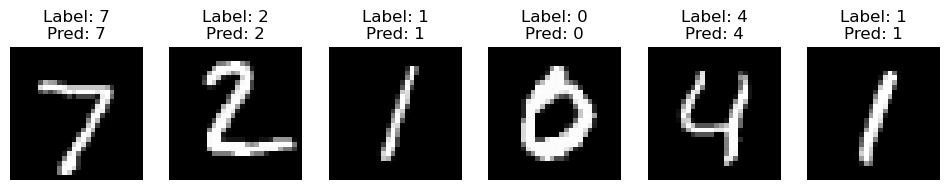

In [23]:
"""
7、完整代码
完整代码如下：
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# 1. 数据加载与预处理
transform = transforms.Compose([
    transforms.ToTensor(),  # 转为张量
    transforms.Normalize((0.5,), (0.5,))  # 归一化到 [-1, 1]
])

# 加载 MNIST 数据集
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# 2. 定义 CNN 模型
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 定义卷积层
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)  # 输入1通道，输出32通道
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)  # 输入32通道，输出64通道
        # 定义全连接层
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # 展平后输入到全连接层
        self.fc2 = nn.Linear(128, 10)  # 10 个类别

    def forward(self, x):
        x = F.relu(self.conv1(x))  # 第一层卷积 + ReLU
        x = F.max_pool2d(x, 2)     # 最大池化
        x = F.relu(self.conv2(x))  # 第二层卷积 + ReLU
        x = F.max_pool2d(x, 2)     # 最大池化
        x = x.view(-1, 64 * 7 * 7) # 展平
        x = F.relu(self.fc1(x))    # 全连接层 + ReLU
        x = self.fc2(x)            # 最后一层输出
        return x

# 创建模型实例
model = SimpleCNN()

# 3. 定义损失函数与优化器
criterion = nn.CrossEntropyLoss()  # 多分类交叉熵损失
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 4. 模型训练
num_epochs = 5
model.train()  # 设置模型为训练模式

for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        outputs = model(images)  # 前向传播
        loss = criterion(outputs, labels)  # 计算损失

        optimizer.zero_grad()  # 清空梯度
        loss.backward()  # 反向传播
        optimizer.step()  # 更新参数

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss / len(train_loader):.4f}")

# 5. 模型测试
model.eval()  # 设置模型为评估模式
correct = 0
total = 0

with torch.no_grad():  # 关闭梯度计算
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

# 6. 可视化测试结果
dataiter = iter(test_loader)
images, labels = next(dataiter)
outputs = model(images)
_, predictions = torch.max(outputs, 1)

fig, axes = plt.subplots(1, 6, figsize=(12, 4))
for i in range(6):
    axes[i].imshow(images[i][0], cmap='gray')
    axes[i].set_title(f"Label: {labels[i]}\nPred: {predictions[i]}")
    axes[i].axis('off')
plt.show()

In [ ]:
"""
图解神经网络：卷积、池化、全连接（通道数问题、kernel与filter的概念）
https://note.youdao.com/web/#/file/WEB3647e790590e68e0ef215d8d0ed6baa3/note/WEBd3c1ca28e670d7e41c54b33e0b2680f6/
"""